 ## General Description
In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

File descriptions
train.csv - the training set
test.csv - the test set
sample_submission.csv - A sample submission in the correct format
enbeddings/ - (see below)
Data fields
qid - unique question identifier
question_text - Quora question text
target - a question labeled "insincere" has a value of 1, otherwise 0
This is a Kernels-only competition. The files in this Data section are downloadable for reference in Stage 1. Stage 2 files will only be available in Kernels and not available for download.

What will be available in the 2nd stage of the competition?
In the second stage of the competition, we will re-run your selected Kernels. The following files will be swapped with new data:

test.csv - This will be swapped with the complete public and private test dataset. This file will have ~56k rows in stage 1 and ~376k rows in stage 2. The public leaderboard data remains the same for both versions. The file name will be the same (both test.csv) to ensure that your code will run.
sample_submission.csv - similar to test.csv, this will be changed from ~56k in stage 1 to ~376k rows in stage 2 . The file name will remain the same.
Embeddings
External data sources are not allowed for this competition. We are, though, providing a number of word embeddings along with the dataset that can be used in the models. These are as follows:

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106
wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

In [35]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 9.9MB/s eta 0:00:01    57% |██████████████████▎             | 675kB 18.1MB/s eta 0:00:01


In [26]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [41]:
train = pd.read_csv("../input/Quora/train.csv")
test = pd.read_csv("../input/Quora/train.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [9]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [11]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

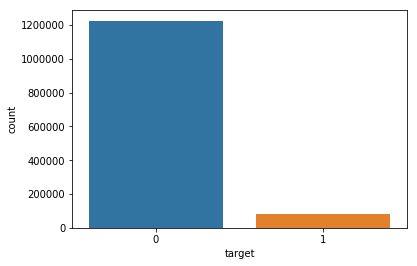

In [28]:
'''
Target Distribution:

First let us look at the distribution of the target variable to understand more about the imbalance and so on.
타겟의 분포가 어떻게 되는지 알아보자 
'''
sns.countplot(train.target)

In [38]:
# Word Frequency plot of sincere & insincere questions:**
'''
각각의 데이터에서 단어의 분포가 어떻게 되는지 
'''
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

    return trace
## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [39]:
!pip install ffmpeg

  Stored in directory: /home/jake/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [40]:
import ffmpeg